In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings  # ✅ Fix: Import warnings to use it later

from IPython.display import display, HTML  # ✅ Fix: Corrected import
from IPython.display import clear_output
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

warnings.filterwarnings('ignore')
display(HTML("<style>.container { width:90% }</style>"))  # ✅ Fix: Corrected HTML tag format
%matplotlib inline

In [25]:
import pandas as pd

# Load the dataset
df = pd.read_csv('transactions_train.csv')

# Display the first few rows of the dataframe
df.head()

,EVENT_ID,account_age_days,transaction_amt,transaction_adj_amt,historic_velocity,ip_address,user_agent,email_domain,phone_number,billing_city,...,transaction_env,EVENT_TIMESTAMP,applicant_name,billing_address,merchant_id,locale,tranaction_initiate,days_since_last_logon,inital_amount,EVENT_LABEL
0,2608000,5774.0,2172.0,78.0,4523.0,81.237.240.91,Mozilla/5.0 (iPod; U; CPU iPhone OS 3_0 like M...,graves.org,456-910-9478,South Angelaville,...,R,2021-02-21 16:32:23,Kristi Bell,7683 Chavez Curve,882-35-3409,es_VE,Q,82.0,4609.0,legit
1,214500,5405.0,2887.0,51.0,4057.0,160.32.216.178,Mozilla/5.0 (Macintosh; PPC Mac OS X 10 10_7) ...,howard-madden.com,269.363.8079,Lake Leslietown,...,O,2020-12-30 11:36:17,Amanda Bond,628 Cline Streets,453-93-1357,bhb_IN,S,2.0,12384.0,legit
2,294600,6570.0,2887.0,56.0,5602.0,109.156.235.28,Mozilla/5.0 (Windows NT 6.2) AppleWebKit/535.2...,walsh-goodwin.com,366.185.9975,Lake Kendra,...,C,2021-03-24 05:34:28,Joanna Walton,268 Ashley Plaza Apt. 416,554-51-8940,mi_NZ,W,43.0,9607.0,legit
3,477060,3865.0,1591.0,58.0,3926.0,158.152.249.45,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,gonzalez-diaz.com,816-365-8213,East Maryport,...,G,2021-10-12 16:24:49,Matthew Johnson,8377 Jacob Course,492-66-7677,yue_HK,Y,71.0,10305.0,legit
4,1993100,6625.0,3297.0,70.0,6675.0,167.164.91.31,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,bender-rocha.info,001-970-935-1735x19620,Yorkburgh,...,W,2021-06-23 00:05:15,Susan Phillips,401 Christopher Meadows,468-86-6030,gd_GB,Q,52.0,4139.0,legit


In [26]:
# Identify categorical and numerical columns
categorical_cols = ['tranaction_initiate', 'currency']
numerical_cols = ["account_age_days",	"transaction_amt",	"transaction_adj_amt",	"historic_velocity"]
feature_names = categorical_cols + numerical_cols
# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)])

# Define the target variable
y = df['EVENT_LABEL'].map({'legit': 0, 'fraud': 1})  # Convert to binary
X = df.drop('EVENT_LABEL', axis=1)

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X[feature_names], y, test_size=0.3, random_state=0)


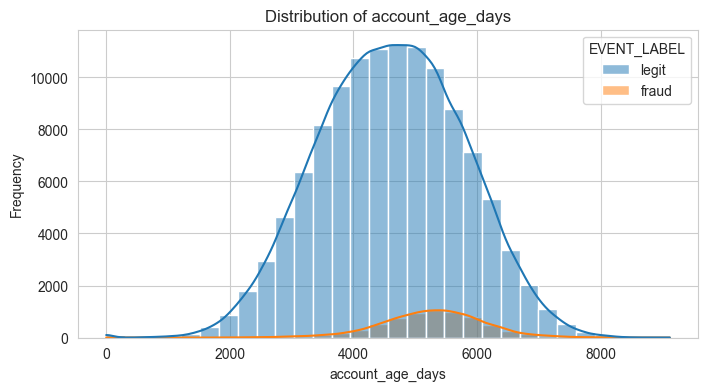

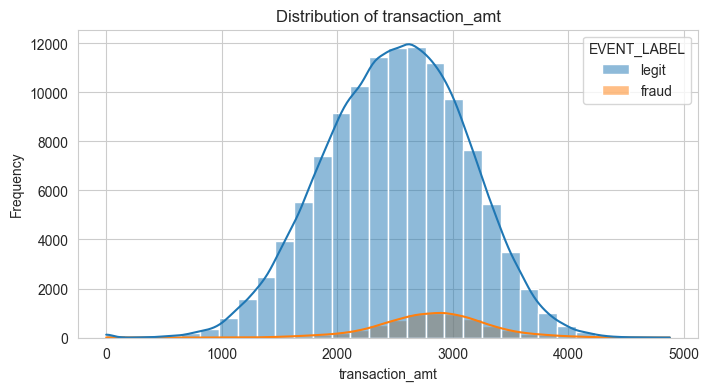

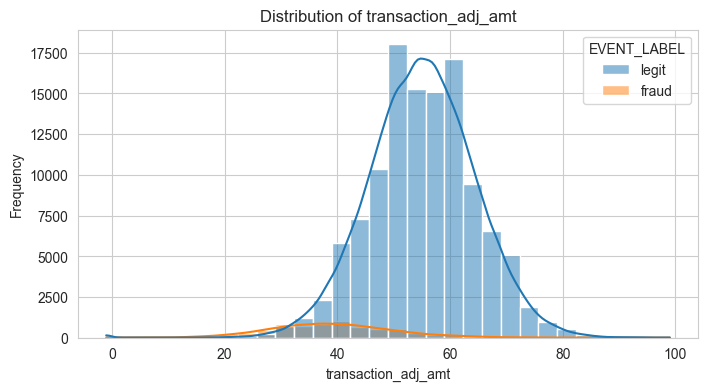

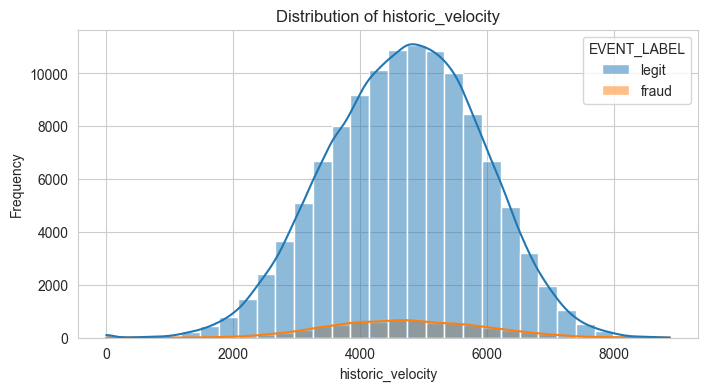

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the aesthetic style of the plots
sns.set_style("whitegrid")

for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(data= df, x=col, hue="EVENT_LABEL", kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()


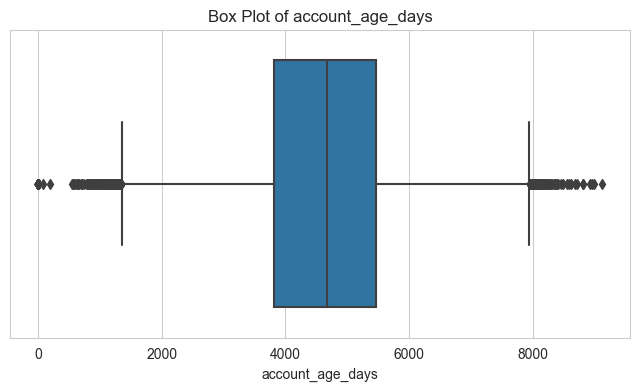

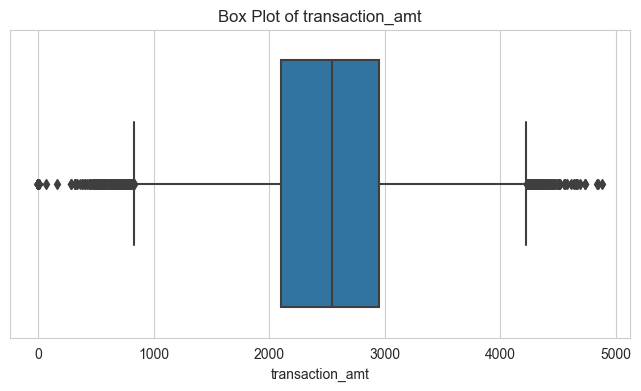

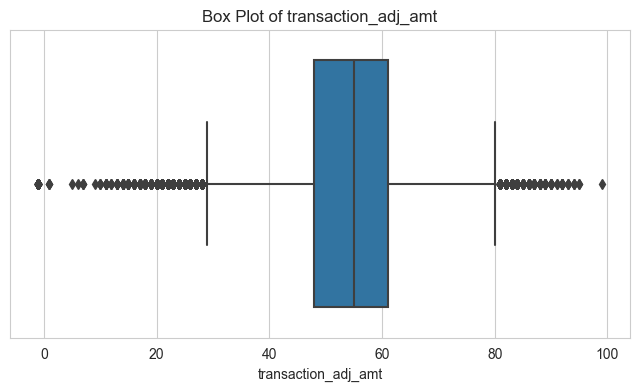

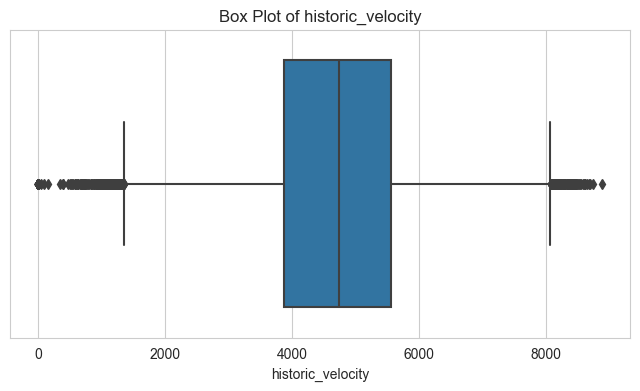

In [28]:
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data= df, x=col, hue="EVENT_LABEL")
    plt.title(f'Box Plot of {col}')
    plt.xlabel(col)
    plt.show()


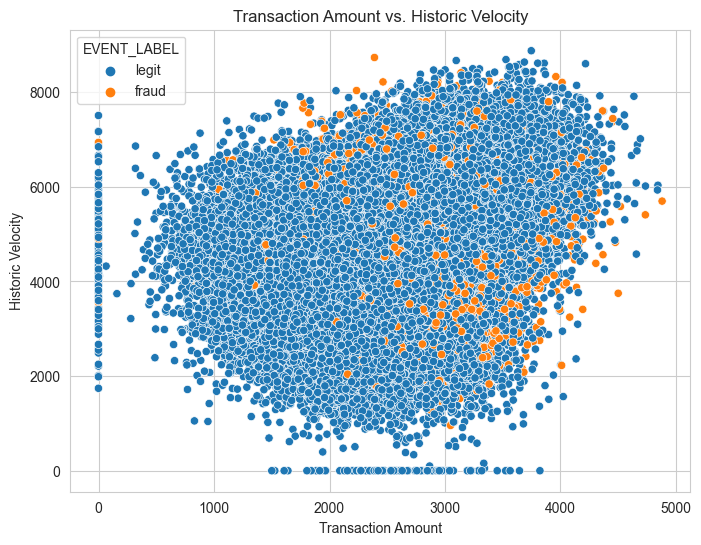

In [29]:
# Example scatter plot between 'transaction_amt' and 'historic_velocity'
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='transaction_amt', y='historic_velocity', hue='EVENT_LABEL')
plt.title('Transaction Amount vs. Historic Velocity')
plt.xlabel('Transaction Amount')
plt.ylabel('Historic Velocity')
plt.show()


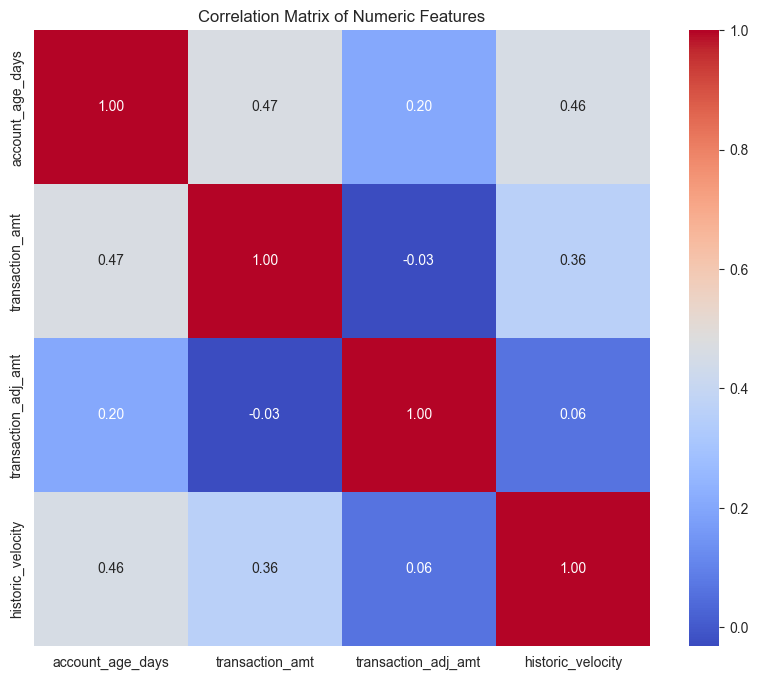

In [30]:
# Compute the correlation matrix
corr = df[numerical_cols].corr()

# Generate a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Matrix of Numeric Features')
plt.show()


In [31]:
def plot_class_distribution(y, title='Class distribution'):
    counter = Counter(y)
    plt.figure(figsize=(10, 3))
    plt.bar(counter.keys(), counter.values())
    plt.title(title)
    plt.ylabel('Frequency')
    plt.xlabel('Class')
    plt.xticks(list(counter.keys()))
    plt.show()

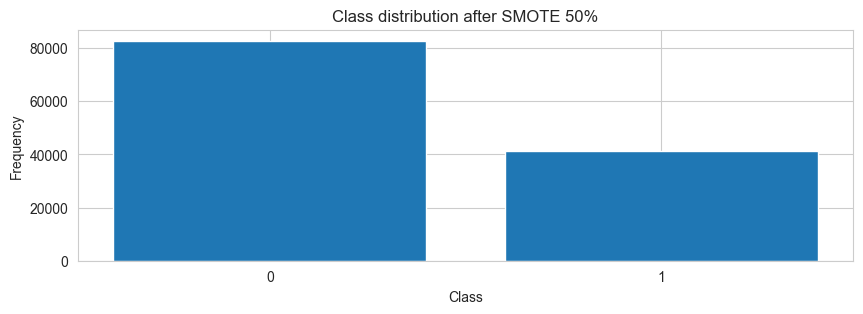

In [32]:
#1. fit your preprocessor & apply it to both Train and Test
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

# -- smote --
smote = SMOTE(random_state=42, sampling_strategy=0.5)
X_smote, y_smote = smote.fit_resample(X_train_prep, y_train)
plot_class_distribution(y_smote, 'Class distribution after SMOTE 50%')

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

# Define the Logistic Regression pipeline
lr_pipeline = LogisticRegression(random_state=0, max_iter=300)

# Train the Logistic Regression model
lr_pipeline.fit(X_smote, y_smote)

# Predictions for test set
lr_predictions = lr_pipeline.predict(X_test_prep)
lr_probabilities = lr_pipeline.predict_proba(X_test_prep)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, lr_predictions):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, lr_probabilities):.4f}")
print(f"Precision: {precision_score(y_test, lr_predictions):.4f}")
print(f"Recall: {recall_score(y_test, lr_predictions):.4f}")
print(f"F1-Score: {f1_score(y_test, lr_predictions):.4f}")


Accuracy: 0.9153
AUC-ROC: 0.9091
Precision: 0.3663
Recall: 0.7427
F1-Score: 0.4906


In [34]:
# prompt: extract feature names and position from pipeline to do logisic feature importance

feature_names = preprocessor.get_feature_names_out()
feature_importance = lr_pipeline.coef_
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance[0]})
feature_importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)

,feature,importance
0,num__account_age_days,1.297743
1,cat__currency_eur,0.388001
2,num__transaction_amt,0.364454
3,cat__tranaction_initiate_D,0.220741
4,cat__tranaction_initiate_N,0.160085
5,cat__tranaction_initiate_S,0.120351
6,cat__tranaction_initiate_H,0.052933
7,cat__tranaction_initiate_X,0.036240
8,cat__tranaction_initiate_L,0.032384
9,cat__tranaction_initiate_W,0.030251


In [35]:
# Logistic Regression coefficients as feature importance
lr_coefficients = lr_pipeline.coef_[0]

# Aligning feature names and coefficients
lr_feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': lr_coefficients})
lr_feature_importance_df = lr_feature_importance_df.sort_values(by='Coefficient', ascending=False)
lr_feature_importance_df.head(10)


,Feature,Coefficient
0,num__account_age_days,1.297743
31,cat__currency_eur,0.388001
1,num__transaction_amt,0.364454
7,cat__tranaction_initiate_D,0.220741
17,cat__tranaction_initiate_N,0.160085
22,cat__tranaction_initiate_S,0.120351
11,cat__tranaction_initiate_H,0.052933
27,cat__tranaction_initiate_X,0.036240
15,cat__tranaction_initiate_L,0.032384
26,cat__tranaction_initiate_W,0.030251


In [36]:
from sklearn.metrics import roc_curve
import numpy as np

# Predict probabilities for the positive class
y_scores = lr_pipeline.predict_proba(X_test_prep)[:, 1]
lr_fpr, lr_tpr, thresholds = roc_curve(y_test, y_scores)
# Define target FPR values
target_fpr = np.arange(0.01, 0.11, 0.01)  # From 1% to 10%

# Interpolate to find TPR and threshold for target FPRs
interp_tpr = np.interp(target_fpr, lr_fpr, lr_tpr)
interp_thresholds = np.interp(target_fpr, lr_fpr, thresholds)

# Print the results
for i in range(len(target_fpr)):
    print(f"Target FPR: {target_fpr[i]:.2f}, Expected TPR: {interp_tpr[i]:.4f}, Threshold: {interp_thresholds[i]:.4f}")

Target FPR: 0.01, Expected TPR: 0.4325, Threshold: 0.8521
Target FPR: 0.02, Expected TPR: 0.5481, Threshold: 0.7639
Target FPR: 0.03, Expected TPR: 0.6087, Threshold: 0.7029
Target FPR: 0.04, Expected TPR: 0.6534, Threshold: 0.6468
Target FPR: 0.05, Expected TPR: 0.6898, Threshold: 0.5957
Target FPR: 0.06, Expected TPR: 0.7175, Threshold: 0.5522
Target FPR: 0.07, Expected TPR: 0.7359, Threshold: 0.5165
Target FPR: 0.08, Expected TPR: 0.7510, Threshold: 0.4840
Target FPR: 0.09, Expected TPR: 0.7646, Threshold: 0.4524
Target FPR: 0.10, Expected TPR: 0.7869, Threshold: 0.4248


In [37]:
# Create a DataFrame from the target FPR, interpolated TPR, and interpolated thresholds
target_fpr_df = pd.DataFrame({
    'Target FPR (%)': target_fpr * 100,  # Convert to percentage
    'Expected TPR': interp_tpr,
    'Threshold': interp_thresholds
})

# Display the DataFrame
target_fpr_df

,Target FPR (%),Expected TPR,Threshold
0,1.0,0.432524,0.852142
1,2.0,0.548058,0.763875
2,3.0,0.608738,0.702929
3,4.0,0.653398,0.646808
4,5.0,0.689806,0.595718
5,6.0,0.717476,0.552196
6,7.0,0.735922,0.516466
7,8.0,0.750971,0.484002
8,9.0,0.764563,0.452408
9,10.0,0.786893,0.424783


In [38]:
from sklearn.ensemble import RandomForestClassifier

# Define the Random Forest pipeline
rf_pipeline = RandomForestClassifier(n_estimators=50, n_jobs = -1, random_state=0)

# Train the Random Forest model
rf_pipeline.fit(X_smote, y_smote)

# Predict and evaluate the model
rf_predictions = rf_pipeline.predict(X_test_prep)
rf_predictions_proba = rf_pipeline.predict_proba(X_test_prep)[:,1]

print(f"Accuracy: {accuracy_score(y_test, rf_predictions):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, rf_predictions_proba):.4f}")
print(f"Precision: {precision_score(y_test, rf_predictions):.4f}")
print(f"Recall: {recall_score(y_test, rf_predictions):.4f}")
print(f"F1-Score: {f1_score(y_test, rf_predictions):.4f}")


Accuracy: 0.9547
AUC-ROC: 0.9074
Precision: 0.5798
Recall: 0.6403
F1-Score: 0.6085


In [39]:
param_grid = {
    'n_estimators': [50, 100],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 2, 3]
}

grid_search = GridSearchCV(estimator=rf_pipeline, param_grid=param_grid, cv=3, scoring='roc_auc', verbose=1, n_jobs=-1)

grid_search.fit(X_smote, y_smote)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best Score: 0.9888854749815303


In [40]:
rf_grid = RandomForestClassifier(n_estimators=100, n_jobs = -1, max_depth = 5,  min_samples_leaf = 4, min_samples_split = 5, random_state=0)

rf_grid.fit(X_smote, y_smote)

RandomForestClassifier(max_depth=5, min_samples_leaf=4, min_samples_split=5,
                       n_jobs=-1, random_state=0)

In [41]:
rf_predictions = rf_grid.predict(X_test_prep)
rf_predictions_proba = rf_grid.predict_proba(X_test_prep)[:,1]

print(f"Accuracy: {accuracy_score(y_test, rf_predictions):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, rf_predictions_proba):.4f}")
print(f"Precision: {precision_score(y_test, rf_predictions):.4f}")
print(f"Recall: {recall_score(y_test, rf_predictions):.4f}")
print(f"F1-Score: {f1_score(y_test, rf_predictions):.4f}")

Accuracy: 0.9344
AUC-ROC: 0.9058
Precision: 0.4343
Recall: 0.6432
F1-Score: 0.5185


In [42]:
from sklearn.metrics import roc_curve
import numpy as np
# Predict probabilities for the positive class
y_scores = rf_grid.predict_proba(X_test_prep)[:, 1]
rf_fpr, rf_tpr, thresholds = roc_curve(y_test, y_scores)
# Define target FPR values
target_fpr = np.arange(0.01, 0.11, 0.01)  # From 1% to 10%

# Interpolate to find TPR and threshold for target FPRs
interp_tpr = np.interp(target_fpr, rf_fpr, rf_tpr)
interp_thresholds = np.interp(target_fpr, rf_fpr, thresholds)

# Print the results
for i in range(len(target_fpr)):
    print(f"Target FPR: {target_fpr[i]:.2f}, Expected TPR: {interp_tpr[i]:.4f}, Threshold: {interp_thresholds[i]:.4f}")


Target FPR: 0.01, Expected TPR: 0.4034, Threshold: 0.6238
Target FPR: 0.02, Expected TPR: 0.4985, Threshold: 0.5966
Target FPR: 0.03, Expected TPR: 0.5650, Threshold: 0.5644
Target FPR: 0.04, Expected TPR: 0.6134, Threshold: 0.5319
Target FPR: 0.05, Expected TPR: 0.6485, Threshold: 0.4951
Target FPR: 0.06, Expected TPR: 0.6762, Threshold: 0.4600
Target FPR: 0.07, Expected TPR: 0.7015, Threshold: 0.4269
Target FPR: 0.08, Expected TPR: 0.7296, Threshold: 0.3940
Target FPR: 0.09, Expected TPR: 0.7442, Threshold: 0.3772
Target FPR: 0.10, Expected TPR: 0.7592, Threshold: 0.3622


In [43]:
import pandas as pd

# Create a DataFrame from the target FPR, interpolated TPR, and interpolated thresholds
target_fpr_df = pd.DataFrame({
    'Target FPR (%)': target_fpr * 100,  # Convert to percentage
    'Expected TPR': interp_tpr,
    'Threshold': interp_thresholds
})

# Display the DataFrame
target_fpr_df


,Target FPR (%),Expected TPR,Threshold
0,1.0,0.403398,0.623839
1,2.0,0.498544,0.596575
2,3.0,0.565049,0.564381
3,4.0,0.613398,0.531872
4,5.0,0.648544,0.495069
5,6.0,0.676214,0.460019
6,7.0,0.701456,0.426904
7,8.0,0.729612,0.393951
8,9.0,0.744175,0.377237
9,10.0,0.759223,0.362222


In [44]:
# Adjusting the feature name extraction for OneHotEncoder to use get_feature_names_out
feature_names = list(preprocessor.transformers_[0][2]) + \
    list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols))

rf_importances = rf_grid.feature_importances_

# Display the top 10 features
rf_feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': rf_importances})
rf_feature_importance_df = rf_feature_importance_df.sort_values(by='Importance', ascending=False)
rf_feature_importance_df.head(10)


,Feature,Importance
2,transaction_adj_amt,0.571505
0,account_age_days,0.162312
1,transaction_amt,0.144743
3,historic_velocity,0.056393
31,currency_eur,0.016743
30,currency_cad,0.016214
32,currency_usd,0.015859
19,tranaction_initiate_P,0.002126
22,tranaction_initiate_S,0.001943
18,tranaction_initiate_O,0.001899


In [45]:
# Define the Logistic Regression pipeline
gbm_pipeline = GradientBoostingClassifier(n_estimators = 100, random_state = 0)

# Train the Logistic Regression model
gbm_pipeline.fit(X_smote, y_smote)

# Predictions for test set
gbm_predictions = gbm_pipeline.predict(X_test_prep)
gbm_predictions_proba = gbm_pipeline.predict_proba(X_test_prep)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, gbm_predictions):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, gbm_predictions_proba):.4f}")
print(f"Precision: {precision_score(y_test, gbm_predictions):.4f}")
print(f"Recall: {recall_score(y_test, gbm_predictions):.4f}")
print(f"F1-Score: {f1_score(y_test, gbm_predictions):.4f}")

Accuracy: 0.9375
AUC-ROC: 0.9167
Precision: 0.4569
Recall: 0.7262
F1-Score: 0.5609


In [46]:
param_grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [100, 200]
}

grid_search = GridSearchCV(estimator=gbm_pipeline, param_grid=param_grid, cv=3, scoring='roc_auc', verbose=1, n_jobs=-1)

grid_search.fit(X_smote, y_smote)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters: {'learning_rate': 0.2, 'n_estimators': 200}
Best Score: 0.9855423953860317


In [47]:
gbm_grid = GradientBoostingClassifier(learning_rate = 0.2, n_estimators = 200, random_state=0)

gbm_grid.fit(X_smote, y_smote)

GradientBoostingClassifier(learning_rate=0.2, n_estimators=200, random_state=0)

In [48]:
from sklearn.metrics import roc_curve
import numpy as np
# Predict probabilities for the positive class
y_scores = gbm_grid.predict_proba(X_test_prep)[:, 1]
gbm_fpr, gbm_tpr, thresholds = roc_curve(y_test, y_scores)
# Define target FPR values
target_fpr = np.arange(0.01, 0.11, 0.01)  # From 1% to 10%

# Interpolate to find TPR and threshold for target FPRs
interp_tpr = np.interp(target_fpr, gbm_fpr, gbm_tpr)
interp_thresholds = np.interp(target_fpr, gbm_fpr, thresholds)

# Print the results
for i in range(len(target_fpr)):
    print(f"Target FPR: {target_fpr[i]:.2f}, Expected TPR: {interp_tpr[i]:.4f}, Threshold: {interp_thresholds[i]:.4f}")


Target FPR: 0.01, Expected TPR: 0.5262, Threshold: 0.6853
Target FPR: 0.02, Expected TPR: 0.6102, Threshold: 0.5373
Target FPR: 0.03, Expected TPR: 0.6709, Threshold: 0.4253
Target FPR: 0.04, Expected TPR: 0.7112, Threshold: 0.3388
Target FPR: 0.05, Expected TPR: 0.7403, Threshold: 0.2802
Target FPR: 0.06, Expected TPR: 0.7617, Threshold: 0.2378
Target FPR: 0.07, Expected TPR: 0.7835, Threshold: 0.2049
Target FPR: 0.08, Expected TPR: 0.7961, Threshold: 0.1816
Target FPR: 0.09, Expected TPR: 0.8078, Threshold: 0.1600
Target FPR: 0.10, Expected TPR: 0.8165, Threshold: 0.1430


In [49]:
import pandas as pd

# Create a DataFrame from the target FPR, interpolated TPR, and interpolated thresholds
target_fpr_df = pd.DataFrame({
    'Target FPR (%)': target_fpr * 100,  # Convert to percentage
    'Expected TPR': interp_tpr,
    'Threshold': interp_thresholds
})

# Display the DataFrame
target_fpr_df

,Target FPR (%),Expected TPR,Threshold
0,1.0,0.526214,0.685309
1,2.0,0.610194,0.537334
2,3.0,0.670874,0.425258
3,4.0,0.711165,0.338773
4,5.0,0.740291,0.280229
5,6.0,0.761650,0.237848
6,7.0,0.783495,0.204883
7,8.0,0.796117,0.181634
8,9.0,0.807767,0.160018
9,10.0,0.816505,0.142956


In [50]:
# Adjusting the feature name extraction for OneHotEncoder to use get_feature_names_out
feature_names = list(preprocessor.transformers_[0][2]) + \
    list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols))

gbm_importances = gbm_grid.feature_importances_

# Display the top 10 features
gbm_feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': rf_importances})
gbm_feature_importance_df = rf_feature_importance_df.sort_values(by='Importance', ascending=False)
gbm_feature_importance_df.head(10)


,Feature,Importance
2,transaction_adj_amt,0.571505
0,account_age_days,0.162312
1,transaction_amt,0.144743
3,historic_velocity,0.056393
31,currency_eur,0.016743
30,currency_cad,0.016214
32,currency_usd,0.015859
19,tranaction_initiate_P,0.002126
22,tranaction_initiate_S,0.001943
18,tranaction_initiate_O,0.001899


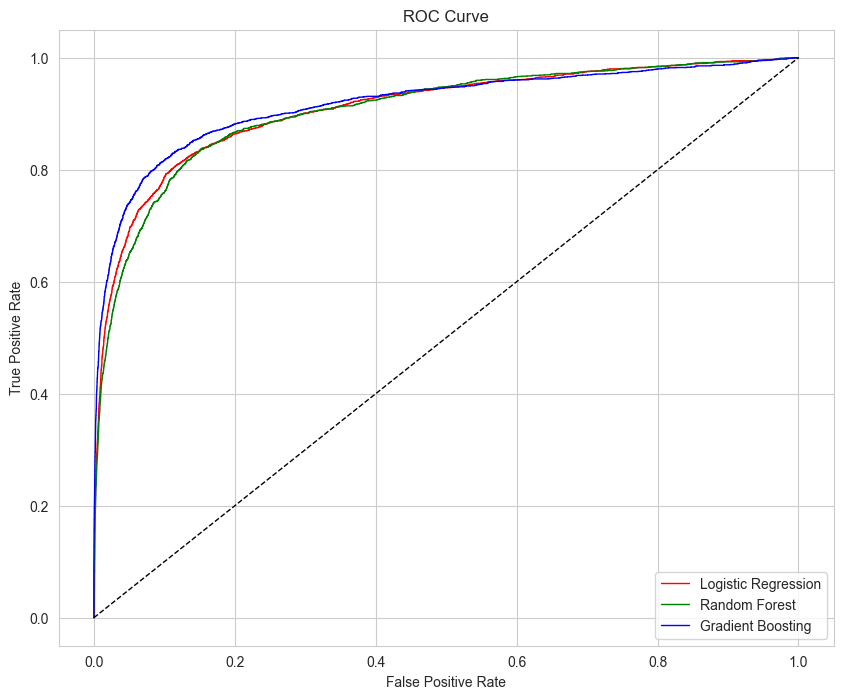

In [51]:
roc_auc_lr = auc(lr_fpr, lr_tpr)
roc_auc_rf = auc(rf_fpr, rf_tpr)
roc_auc_gbm = auc(gbm_fpr, gbm_tpr)

plt.figure(figsize=(10, 8))
plt.plot(lr_fpr, lr_tpr, color='red', lw=1, label='Logistic Regression' % roc_auc_lr)
plt.plot(rf_fpr, rf_tpr, color='green', lw=1, label='Random Forest' % roc_auc_rf)
plt.plot(gbm_fpr, gbm_tpr, color='blue', lw=1, label='Gradient Boosting' % roc_auc_gbm)
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

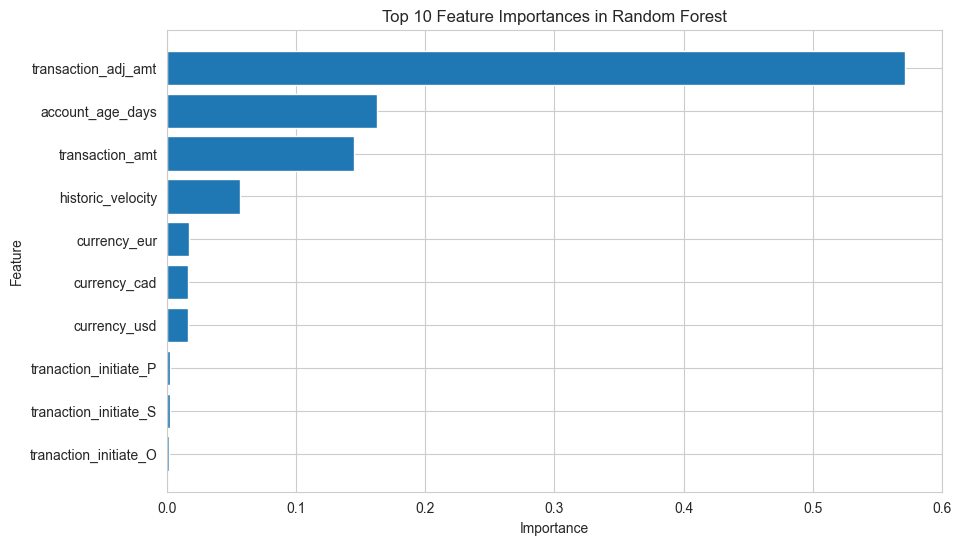

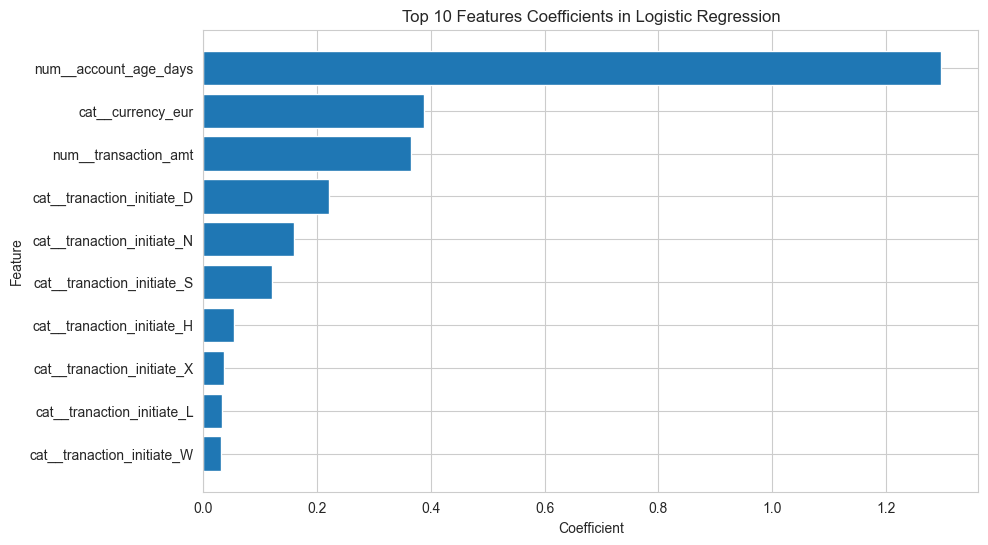

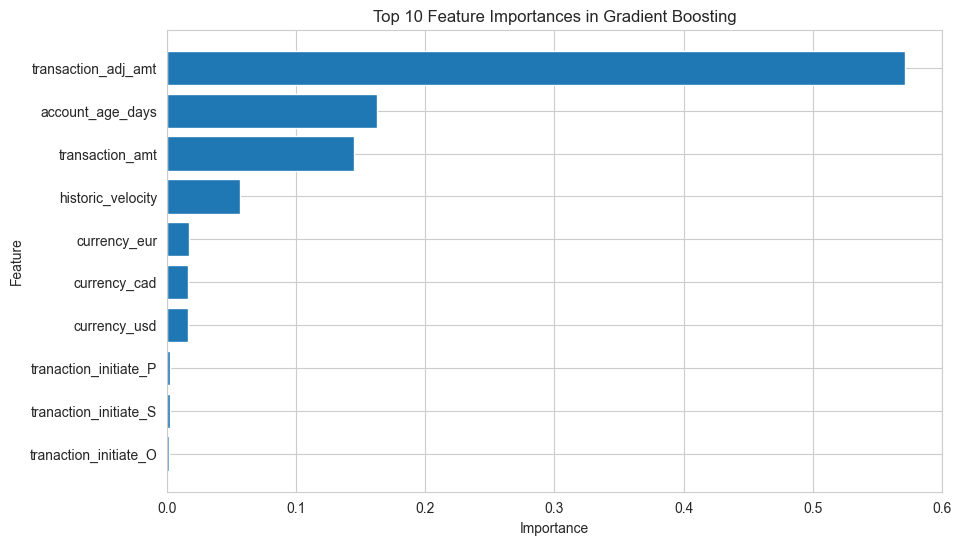

In [52]:
import matplotlib.pyplot as plt

# Plot for Random Forest
plt.figure(figsize=(10, 6))
plt.title('Top 10 Feature Importances in Random Forest')
plt.barh(rf_feature_importance_df['Feature'][:10], rf_feature_importance_df['Importance'][:10])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.show()

# Plot for Logistic Regression
plt.figure(figsize=(10, 6))
plt.title('Top 10 Features Coefficients in Logistic Regression')
plt.barh(lr_feature_importance_df['Feature'][:10], lr_feature_importance_df['Coefficient'][:10])
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.show()


# Plot for Gradient Boosting
plt.figure(figsize=(10, 6))
plt.title('Top 10 Feature Importances in Gradient Boosting')
plt.barh(gbm_feature_importance_df['Feature'][:10], gbm_feature_importance_df['Importance'][:10])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.show()



In [53]:
df_pred = pd.read_csv('transactions_holdout.csv')

In [54]:
X_pred = preprocessor.transform(df_pred)

In [55]:
pred = gbm_grid.predict(X_pred)

In [56]:
df_pred['P_EVENT_LABEL'] = pred

In [57]:
pred_output = df_pred[['EVENT_ID', 'P_EVENT_LABEL']]

In [58]:
pred_output.to_csv('fraud_predictions.csv', index=False)